# Лабораторная работа №2
## Выполнил: Концебалов О.С.
## Группа: М8О-409Б-22

## ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

Загружаем наши датасеты

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

df = pd.read_csv('heart.csv')
print(df.shape)
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

(1025, 14)
   age  sex  cp  trestbps  chol  fbs  ...  exang  oldpeak  slope  ca  thal  target
0   52    1   0       125   212    0  ...      0      1.0      2   2     3       0
1   53    1   0       140   203    1  ...      1      3.1      0   0     3       0
2   70    1   0       145   174    0  ...      1      2.6      0   0     3       0
3   61    1   0       148   203    0  ...      0      0.0      2   1     3       0
4   62    0   0       138   294    1  ...      0      1.9      1   3     2       0

[5 rows x 14 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thala

Обучим базовую модель

In [3]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train, y_train)

y_pred_baseline = baseline_model.predict(X_test)
y_pred_proba_baseline = baseline_model.predict_proba(X_test)[:, 1]

print("base")
print("accuracy", accuracy_score(y_test, y_pred_baseline))



base
accuracy 0.8146341463414634


Получили хороший результат, попробуем улучшить его масштабированием

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_scaled = LogisticRegression(random_state=42, max_iter=1000)
model_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = model_scaled.predict(X_test_scaled)

print("scaled")
print("accuracy:", accuracy_score(y_test, y_pred_scaled))


scaled
accuracy: 0.8097560975609757


Улучшений нет - значит дело не в масштабе, пробуем подтюнить параметры

In [8]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

print("grid")
print("accuracy", accuracy_score(y_test, y_pred_best))

grid
accuracy 0.8195121951219512


Незначительное улучшение, попробуем баласировку классов

In [10]:
model_balanced = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',
    C=1,
    penalty='l2',
    solver='liblinear'
)
model_balanced.fit(X_train_scaled, y_train)
y_pred_balanced = model_balanced.predict(X_test_scaled)

print("balanced")
print("accuracy:", accuracy_score(y_test, y_pred_balanced))

balanced
accuracy: 0.8097560975609757


Гипотеза опять не подтвердилась, попробуем взглянуть на широкое сравнение моделей

In [11]:
results = {
    'base': { 'accuracy': accuracy_score(y_test, y_pred_baseline), 'F1': f1_score(y_test, y_pred_baseline), 'ROC-AUC': roc_auc_score(y_test, y_pred_proba_baseline)
    },
    'scaled': {'accuracy': accuracy_score(y_test, y_pred_scaled),'F1': f1_score(y_test, y_pred_scaled), 'ROC-AUC': roc_auc_score(y_test, model_scaled.predict_proba(X_test_scaled)[:, 1])
    },
    'grid': { 'accuracy': accuracy_score(y_test, y_pred_best), 'F1': f1_score(y_test, y_pred_best), 'ROC-AUC': roc_auc_score(y_test, y_pred_proba_best)
    },
    'balanced': {'accuracy': accuracy_score(y_test, y_pred_balanced),'F1': f1_score(y_test, y_pred_balanced),'ROC-AUC': roc_auc_score(y_test, model_balanced.predict_proba(X_test_scaled)[:, 1])
    }
}

results_df = pd.DataFrame(results).T
print(results_df)

          accuracy        F1   ROC-AUC
base      0.814634  0.836207  0.929810
scaled    0.809756  0.831169  0.929810
grid      0.819512  0.839827  0.932571
balanced  0.809756  0.831169  0.930381


По остальным метрикам также, grid чуть чуть выделяется. Напишем свой вариант

In [12]:
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000, C=1.0):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.C = C  
        self.weights = None
        self.bias = None
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))
    
    def compute_cost(self, y, y_pred):
        m = len(y)
        cost = (-1/m) * np.sum(y * np.log(y_pred + 1e-8) + (1-y) * np.log(1 - y_pred + 1e-8))
        reg_cost = (self.C/(2*m)) * np.sum(self.weights**2)  # L2 регуляризация
        return cost + reg_cost
    
    def fit(self, X, y):
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0
        
        for i in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)
            
            dw = (1/m) * np.dot(X.T, (y_pred - y)) + (self.C/m) * self.weights
            db = (1/m) * np.sum(y_pred - y)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
    
    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)
    
    def predict(self, X, threshold=0.5):
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)
    

custom_model = CustomLogisticRegression(learning_rate=0.1, n_iterations=2000, C=1.0)
custom_model.fit(X_train_scaled, y_train.values)
y_pred_custom = custom_model.predict(X_test_scaled)
y_pred_proba_custom= custom_model.predict_proba(X_test_scaled)

print("my")
print("accuracy:", accuracy_score(y_test, y_pred_custom))


my
accuracy: 0.8097560975609757


Получаем такой же результат, как и в библиотечной функции. Значит все предыдущие идеи дадут нам такой же результат (что видно даже по обучению на масштабированных данных)

## ЛИНЕЙНАЯ РЕГРЕСИИЯ

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
train = pd.read_csv('train.csv')
print(train.shape)
print(train.head())
print(train.info())
print(train.describe())
print(train.isnull().sum())
test = pd.read_csv('test.csv')
test_ids = test['Id'].copy()
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)


(1460, 81)
   Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0   1          60       RL  ...        WD         Normal    208500
1   2          20       RL  ...        WD         Normal    181500
2   3          60       RL  ...        WD         Normal    223500
3   4          70       RL  ...        WD        Abnorml    140000
4   5          60       RL  ...        WD         Normal    250000

[5 rows x 81 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour 

Подготовим данные для обучения библиотечной модели

In [62]:
X = train.drop(['SalePrice'], axis=1)
y = train['SalePrice']
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'lin reg': LinearRegression(), 'ridge': Ridge(random_state=42), 'lasso': Lasso(random_state=42)
}
base_results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    base_results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

print("base")
for model_name, metrics in base_results.items():
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")

base

lin reg:
MSE: 7185525149893943920183738368.00
RMSE: 84767476958406.31
MAE: 7009653510471.91
R2: -936795249093979648.00

ridge:
MSE: 883188015.11
RMSE: 29718.48
MAE: 19127.80
R2: 0.88

lasso:
MSE: 884301488.85
RMSE: 29737.21
MAE: 18537.82
R2: 0.88


Попробуем улучшить ridge и посмотрим на данные после логарифмирования - должны приблизиться к нормальным

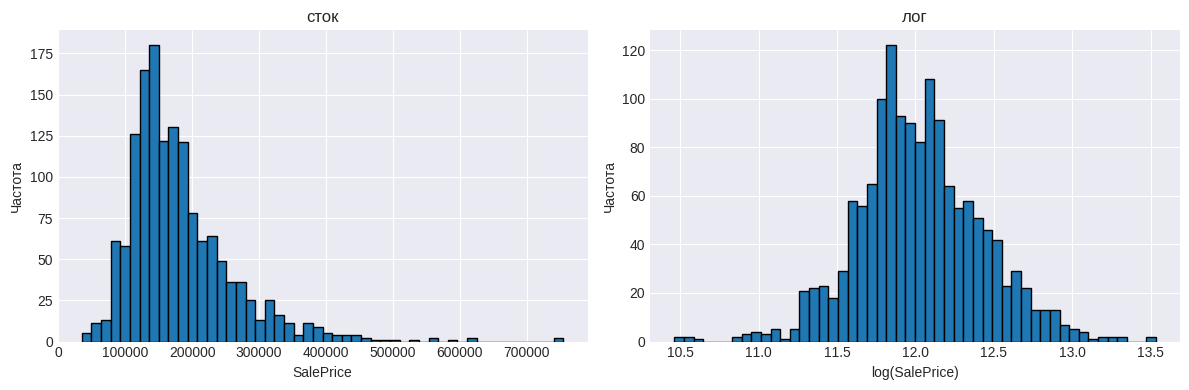

In [63]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y, bins=50, edgecolor='black')
plt.title('сток')
plt.xlabel('SalePrice')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.hist(np.log1p(y), bins=50, edgecolor='black')
plt.title('лог')
plt.xlabel('log(SalePrice)')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

Стало гораздо лучше, введем новые функции, поработаем с корреляцией и гиперпараметрами

In [66]:
def create_features(df):
    df = df.copy()
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBath'] = df['FullBath'] + 0.5*df['HalfBath'] + df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
    df['TotalPorch'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
    df['OverallQual_TotalSF'] = df['OverallQual'] * df['TotalSF']
    return df

X_enhanced = create_features(X)
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(X_enhanced, y, test_size=0.2, random_state=42)
y_train_log = np.log1p(y_train_enh)
y_test_log = np.log1p(y_test_enh)
numeric_data = X_enhanced.select_dtypes(include=[np.number])
correlation_with_target = pd.concat([numeric_data, y_train_enh], axis=1).corr()['SalePrice'].sort_values(ascending=False)
top_features = correlation_with_target[1:31].index.tolist()  # исключаем SalePrice
print(correlation_with_target.head(10))
selected_features = top_features + list(categorical_features)

enhanced_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [f for f in top_features if f in numeric_data.columns]),
        ('cat', categorical_transformer, [f for f in categorical_features if f in selected_features])
    ]
)

enhanced_pipeline = Pipeline(steps=[
    ('preprocessor', enhanced_preprocessor),
    ('model', Ridge())
])
param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__solver': ['auto', 'svd', 'cholesky', 'lsqr']
}
grid_search = GridSearchCV(
    enhanced_pipeline,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_enh[selected_features], y_train_log)
print(grid_search.best_params_)
print(-grid_search.best_score_)

SalePrice              1.000000
OverallQual_TotalSF    0.836603
OverallQual            0.785555
TotalSF                0.765586
GrLivArea              0.695652
GarageCars             0.640991
GarageArea             0.624139
TotalBath              0.621280
TotalBsmtSF            0.597766
1stFlrSF               0.587883
Name: SalePrice, dtype: float64
Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'model__alpha': 10, 'model__solver': 'auto'}
0.14180119616280334


Попробуем обучить модель на этом пайплайне

In [67]:
best_model = grid_search.best_estimator_
best_model.fit(X_train_enh[selected_features], y_train_log)
y_pred_log = best_model.predict(X_test_enh[selected_features])
y_pred = np.expm1(y_pred_log)
enhanced_metrics = {
    'MSE': mean_squared_error(y_test_enh, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test_enh, y_pred)),
    'MAE': mean_absolute_error(y_test_enh, y_pred),
    'R2': r2_score(y_test_enh, y_pred)
}

print("\nimpr")
for metric, value in enhanced_metrics.items():
    print(f"{metric}: {value:.2f}")


impr
MSE: 752343078.47
RMSE: 27428.87
MAE: 16741.15
R2: 0.90


Получилось довольно неплохо, напишем свою имплементацию

In [70]:
class CustomLinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.loss_history = []
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        for i in range(self.n_iterations):
            y_pred = np.dot(X, self.weights) + self.bias
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)          
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db 
            loss = np.mean((y_pred - y) ** 2)
            self.loss_history.append(loss)
    
    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

X_custom = X_enhanced[selected_features].copy()
X_processed = enhanced_preprocessor.fit_transform(X_custom, y)
X_train_custom, X_test_custom, y_train_custom, y_test_custom = train_test_split(
    X_processed, np.log1p(y), test_size=0.2, random_state=42)
custom_model = CustomLinearRegression(learning_rate=0.001, n_iterations=5000)
custom_model.fit(X_train_custom, y_train_custom)
y_pred_custom_log = custom_model.predict(X_test_custom)
y_pred_custom = np.expm1(y_pred_custom_log)

custom_metrics = {
    'MSE': mean_squared_error(np.expm1(y_test_custom), y_pred_custom),
    'RMSE': np.sqrt(mean_squared_error(np.expm1(y_test_custom), y_pred_custom)),
    'MAE': mean_absolute_error(np.expm1(y_test_custom), y_pred_custom),
    'R2': r2_score(np.expm1(y_test_custom), y_pred_custom)
}

print("\nmy")
for metric, value in custom_metrics.items():
    print(f"{metric}: {value:.2f}")


my
MSE: 3475186435.19
RMSE: 58950.71
MAE: 45060.32
R2: 0.55


Ожидаемо обычная регрессия так себе, поэтому пишем ridge

out 387


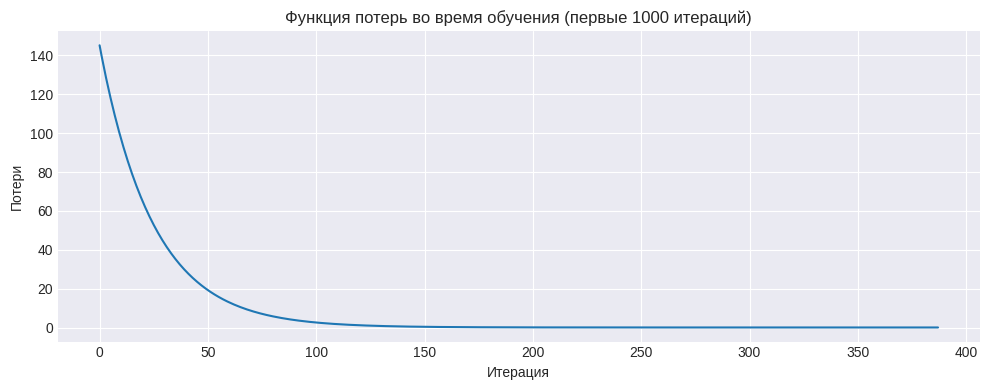

In [71]:
X_train_enh_selected = X_train_enh[selected_features]
X_test_enh_selected = X_test_enh[selected_features]
enhanced_preprocessor.fit(X_train_enh_selected, y_train_log)
X_train_custom_processed = enhanced_preprocessor.transform(X_train_enh_selected)
X_test_custom_processed = enhanced_preprocessor.transform(X_test_enh_selected)

class CustomRidgeRegressionOptimized:
    def __init__(self, alpha=1.0, learning_rate=0.01, n_iterations=5000, early_stopping=True, tol=1e-4):
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.early_stopping = early_stopping
        self.tol = tol
        self.weights = None
        self.bias = None
        self.loss_history = []
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0
        X_normalized = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)
        prev_loss = float('inf')
        
        for i in range(self.n_iterations):
            y_pred = np.dot(X_normalized, self.weights) + self.bias
            mse_loss = np.mean((y_pred - y) ** 2)
            reg_loss = self.alpha * np.sum(self.weights ** 2)
            total_loss = mse_loss + reg_loss
            self.loss_history.append(total_loss)
            dw = (2/n_samples) * np.dot(X_normalized.T, (y_pred - y)) + (2 * self.alpha * self.weights)
            db = (2/n_samples) * np.sum(y_pred - y)
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            if self.early_stopping and i > 10:
                loss_change = abs(total_loss - prev_loss)
                if loss_change < self.tol:
                    print(f"out {i}")
                    break
            prev_loss = total_loss
            if i % 1000 == 0 and i > 0:
                self.learning_rate *= 0.9
    
    def predict(self, X):
        X_normalized = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)
        return np.dot(X_normalized, self.weights) + self.bias
    

custom_ridge_opt = CustomRidgeRegressionOptimized(
    alpha=10,  
    learning_rate=0.01,
    n_iterations=10000,
    early_stopping=True,
    tol=1e-6
)
custom_ridge_opt.fit(X_train_custom_processed, y_train_log)
plt.figure(figsize=(10, 4))
plt.plot(custom_ridge_opt.loss_history[:1000])
plt.title('Функция потерь во время обучения (первые 1000 итераций)')
plt.xlabel('Итерация')
plt.ylabel('Потери')
plt.grid(True)
plt.tight_layout()
plt.show()

In [72]:
y_pred_custom_ridge_opt_log = custom_ridge_opt.predict(X_test_custom_processed)
y_pred_custom_ridge_opt = np.expm1(y_pred_custom_ridge_opt_log)
custom_ridge_opt_metrics = {
    'MSE': mean_squared_error(y_test_enh, y_pred_custom_ridge_opt),
    'RMSE': np.sqrt(mean_squared_error(y_test_enh, y_pred_custom_ridge_opt)),
    'MAE': mean_absolute_error(y_test_enh, y_pred_custom_ridge_opt),
    'R2': r2_score(y_test_enh, y_pred_custom_ridge_opt)
}

print("\nmyridge")
for metric, value in custom_ridge_opt_metrics.items():
    print(f"{metric}: {value:.2f}")


myridge
MSE: 2529330298.34
RMSE: 50292.45
MAE: 29285.29
R2: 0.67


Результаты стали гораздо лучше